# Условия 

Вы работаете в компании, которая занимается продажей автомобилей с пробегом в Москве. 

Основная задача компании и её менеджеров — максимально быстро находить выгодные предложения (проще говоря, купить ниже рынка, а продать дороже рынка). 

Руководство компании просит вашу команду создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам.

Если такая модель будет работать хорошо, то вы сможете быстро выявлять выгодные предложения (когда желаемая цена продавца ниже предсказанной рыночной цены). Это значительно ускорит работу менеджеров и повысит прибыль компании.

# ПРОБЛЕМА

Только вот незадача: исторически сложилось, что компания изначально не собирала данные. Есть только небольшой датасет с историей продаж за короткий период, которого для обучения модели будет явно мало. Его мы будем использовать для теста, остальное придется собрать самим.

# Условия соревнования:

* Данное соревнование является бессрочным и доступно для всех потоков.
* Срок выполнения соревнования устанавливаеться индивидуально в каждом потоке.
* Тестовая выборка представлена в ЛидерБорде целиком.
* По этому лучшие и победные решения буду проверяться на их "адекватность" (чтоб не было подгонки под тестовую выборку).
* Разрешено использовать внешние данные. (но их источник должен быть публичным и доступен всем участникам соревнования)
* Разрешено использовать любые ML алгоритмы и библиотеки. (кроме DL)
* Даже если удасться найти исходные объявления из теста - нельзя просто указать их цену. Делаем реальный ML продукт, который потом сможет нормально работать на новых данных.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sys
from pandas import Series
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,RandomForestClassifier, ExtraTreesClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.impute import KNNImputer

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from datetime import datetime
from datetime import timedelta

In [2]:
# Определим отсутствующие данные
def nan_in_table(df):
    x = pd.DataFrame()
    x['Всего NaN'] = df.isna().sum()
    x['% NaN'] = round((x['Всего NaN'] / df.shape[0])*100, 2)
    x = x.sort_values('% NaN', ascending=False) 
    x = x[x['Всего NaN'] > 0]
    return x

def bar_count(column, header=True):
    fig = plt.figure(figsize=(15,10))
    sns.set_style('whitegrid')  
    plt.xticks(rotation=45, fontsize=15)
    plt.legend(fontsize = 15)
    
    if header == True:
        sns.countplot(x=column, data=df, hue=column, dodge=0, color='green')
    else:
        sns.countplot(x=column, data=df, dodge=0, color='green')
    
    val = []
    for i in df[column].value_counts():
        val.append(round((i/df[column].shape[0])*100,2))

    res = {}
    for i,j in zip(df[column].value_counts().index, val):
        res[i] = j

    for i in res.items():
        print(f'{i[0]} : {i[1]}%')
        
def emissions_analys(column):

    median = df[column].median()
    IQR = df[column].quantile(0.75) - df[column].quantile(0.25)
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    start_int = perc25 - 1.5*IQR
    stop_int = perc75 + 1.5*IQR

    top_count = 0
    bot_count = 0

    for i in df[column]:
        if i > stop_int:
            top_count += 1
        elif i < start_int:
            bot_count += 1
        else:
            pass

    res = bot_count + top_count
    
    print(f'Минимальное значение: {df[column].min()} |', f'Максимальное значение: {df[column].max()}', 
          f'Среднее значение: {int(df[column].mean())}')
    print(60*'==')
    print(f'25-й перцентиль: {perc25} |', f'75-й перцентиль: {perc75} |', 
          f'Границы выбросов: [{start_int}, {stop_int}]')
    print(60*'==')
    print(f'Всего выбросов: {res} |', f'Выбросы в нижней границе: {bot_count} |', 
          f'Выбросы в верхней границе: {top_count}')    
    
def distplot(df, column, bins=10):
    fig = plt.figure(figsize=(6,6))
    sns.set_style('whitegrid') 
    plot = sns.distplot(df[column],color='green', bins=bins)
    plt.show()
    
def plot_confusion_matrix(y_true, y_pred, font_scale, classes,
                          normalize=False,
                          title=None):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    list_of_labels = [['TP', 'FP'], ['FN', 'TN']]

    if not title:
        if normalize:
            title = 'Нормализованная матрица ошибок'
        else:
            title = 'Матрица ошибок без нормализации'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    cm[0, 0], cm[1, 1] = cm[1, 1], cm[0, 0]

    # # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.style.use('seaborn-paper')
    cmap = plt.cm.Blues
    color_text = plt.get_cmap('PuBu')(0.85)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries

           title=title)
    ax.title.set_fontsize(15)
    ax.set_ylabel('Предсказанные значения', fontsize=14, color=color_text)
    ax.set_xlabel('Целевая переменная', fontsize=14, color=color_text)
    ax.set_xticklabels(classes, fontsize=12, color='black')
    ax.set_yticklabels(classes, fontsize=12, color='black')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, list_of_labels[i][j] + '\n' + format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def print_metrics(y_test, y_pred):
    print('Accuracy: %.4f' % accuracy_score(y_test, y_pred))
    print('Precision: %.4f' % precision_score(y_test, y_pred))
    print('Recall: %.4f' % recall_score(y_test, y_pred))
    print('F1: %.4f' % f1_score(y_test, y_pred))


In [3]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# Data download

In [4]:
# Загрузка и просмотр данных
df_train = pd.read_csv('all_auto_ru_09_09_2020.csv') # датасет для обучения модели
df_test = pd.read_csv('test.csv')

pd.set_option('display.max_columns', None)

In [5]:
display("train: shape" + str(df_train.shape), df_train.columns)
display("test: shape" +str(df_test.shape), df_test.columns)

'train: shape(89378, 26)'

Index(['bodyType', 'brand', 'color', 'fuelType', 'modelDate', 'name',
       'numberOfDoors', 'productionDate', 'vehicleConfiguration',
       'vehicleTransmission', 'engineDisplacement', 'enginePower',
       'description', 'mileage', 'Комплектация', 'Привод', 'Руль', 'Состояние',
       'Владельцы', 'ПТС', 'Таможня', 'Владение', 'price', 'start_date',
       'hidden', 'model'],
      dtype='object')

'test: shape(34686, 32)'

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня'],
      dtype='object')

In [6]:
print('Тренировочный датасет')
display(nan_in_table(df_train))
print('Тестовый')
display(nan_in_table(df_test))

Тренировочный датасет


,Всего NaN,% NaN
hidden,89378,100.00
Состояние,89378,100.00
Владение,60177,67.33
Владельцы,13588,15.20
description,3254,3.64
price,410,0.46
ПТС,361,0.40
bodyType,1,0.00
Привод,1,0.00
enginePower,1,0.00


Тестовый


,Всего NaN,% NaN
complectation_dict,28268,81.50
Владение,22691,65.42
equipment_dict,9996,28.82
ПТС,1,0.00


In [7]:
# удалим строки, где отсутствует цена
df_train = df_train.dropna(axis=0, subset=['price'])
df_train  = df_train.reset_index(drop=True)

In [8]:
# Количество признаков не совпадает будем оставлять пересечение после объединения датасетов
df_train = df_train[['brand','bodyType','color','fuelType', 'modelDate','numberOfDoors','productionDate',
        'vehicleConfiguration','engineDisplacement','enginePower','mileage','Привод','Руль',
        'Владельцы','ПТС','price']]
df_test = df_test[['brand','bodyType','color','fuelType', 'modelDate','numberOfDoors','productionDate',
        'vehicleConfiguration','engineDisplacement','enginePower','mileage','Привод','Руль',
        'Владельцы','ПТС']]

In [9]:
# Делаем пометку, где тренировочная выборка, где тестовая
df_train['train'] = 1
df_test['train'] = 0

dt =pd.DataFrame()
# объединяем датафреймы
df = df_train.append(df_test, sort=False).reset_index(drop=True) # объединяем датафреймы
df.head(5)

,brand,bodyType,color,fuelType,modelDate,numberOfDoors,productionDate,vehicleConfiguration,engineDisplacement,enginePower,mileage,Привод,Руль,Владельцы,ПТС,price,train
0,AUDI,Седан,040001,бензин,1990.0,4.0,1991,SEDAN MECHANICAL 2.8,2.8,174,350000,полный,LEFT,3,ORIGINAL,200000.0,1
1,AUDI,Седан,EE1D19,бензин,1982.0,4.0,1986,SEDAN MECHANICAL 1.8,1.8,90,173424,передний,LEFT,3,ORIGINAL,60000.0,1
2,AUDI,Универсал 5 дв.,0000CC,бензин,1988.0,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,2.3,136,230000,полный,LEFT,3,ORIGINAL,99000.0,1
3,AUDI,Седан,CACECB,бензин,1988.0,4.0,1989,SEDAN MECHANICAL 1.8,1.8,90,240000,передний,LEFT,3,ORIGINAL,65000.0,1
4,AUDI,Седан,040001,бензин,1990.0,4.0,1991,SEDAN MECHANICAL 2.0,2.0,101,300000,передний,LEFT,3,DUPLICATE,100000.0,1


# Преобразование и чистка данных

In [10]:
#переименуем колоки для удобства
df.columns = ['brand', 'body', 'color', 'fuel', 'modelDate','doors', 'prod_date', 'config',
       'engine', 'power', 'mileage', 'drive', 'wheel', 'owner',
       'tech_passport', 'price', 'train']

In [11]:
df

,brand,body,color,fuel,modelDate,doors,prod_date,config,engine,power,mileage,drive,wheel,owner,tech_passport,price,train
0,AUDI,Седан,040001,бензин,1990.0,4.0,1991,SEDAN MECHANICAL 2.8,2.8,174,350000,полный,LEFT,3,ORIGINAL,200000.0,1
1,AUDI,Седан,EE1D19,бензин,1982.0,4.0,1986,SEDAN MECHANICAL 1.8,1.8,90,173424,передний,LEFT,3,ORIGINAL,60000.0,1
2,AUDI,Универсал 5 дв.,0000CC,бензин,1988.0,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,2.3,136,230000,полный,LEFT,3,ORIGINAL,99000.0,1
3,AUDI,Седан,CACECB,бензин,1988.0,4.0,1989,SEDAN MECHANICAL 1.8,1.8,90,240000,передний,LEFT,3,ORIGINAL,65000.0,1
4,AUDI,Седан,040001,бензин,1990.0,4.0,1991,SEDAN MECHANICAL 2.0,2.0,101,300000,передний,LEFT,3,DUPLICATE,100000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123649,BMW,седан,коричневый,бензин,2011.0,4.0,2014,SEDAN AUTOMATIC 1.6,1.6 LTR,136 N12,115000,задний,Левый,3 или более,Оригинал,NaN,0
123650,BMW,седан,чёрный,дизель,2016.0,4.0,2018,SEDAN AUTOMATIC 2.0,2.0 LTR,190 N12,98000,полный,Левый,1 владелец,Оригинал,NaN,0
123651,BMW,седан,серый,бензин,1995.0,4.0,1997,SEDAN AUTOMATIC 2.5,2.5 LTR,170 N12,360000,задний,Левый,3 или более,Дубликат,NaN,0
123652,BMW,внедорожник 5 дв.,коричневый,дизель,2012.0,5.0,2013,ALLROAD_5_DOORS AUTOMATIC 2.0,2.0 LTR,184 N12,90500,полный,Левый,2 владельца,Оригинал,NaN,0


# Owner

In [12]:
owner = []
for i in df.owner:
    res = str(i).strip()
    res = res.replace('3 или более', '3.0').replace('2\xa0владельца', '2.0').replace('1\xa0владелец', '1.0')
    if res == '3.0':
        owner.append(int(3))
    elif res == '2.0':
        owner.append(int(2))    
    elif res == '1.0':
        owner.append(int(1))
    else:
        owner.append(None)
        
df['owner'] = owner

In [13]:
# Для заполнения пропусков в признаке OWNER воспользуемся встроенным модулем scikitlearn KNNImputer.
train_knn = df[['owner']]
imputer = KNNImputer(n_neighbors = 5)

# создаем словарь из списка типов образования (0 -самое популярной, школьное и т.д.)
edu = df.owner.value_counts().index.to_list() 
edu_dict = {}
for counter, edu_word in enumerate(edu):
    edu_dict[edu_word] = counter

train_knn['owner'].replace(edu_dict, inplace=True)
df_fill = imputer.fit_transform(train_knn)
df.loc[:, 'owner'] = np.round(df_fill.T[0],0).astype(int)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [14]:
nan_in_table(df).head()

,Всего NaN,% NaN
price,34686,28.05
tech_passport,362,0.29
power,1,0.00
drive,1,0.00
engine,1,0.00


In [15]:
df

,brand,body,color,fuel,modelDate,doors,prod_date,config,engine,power,mileage,drive,wheel,owner,tech_passport,price,train
0,AUDI,Седан,040001,бензин,1990.0,4.0,1991,SEDAN MECHANICAL 2.8,2.8,174,350000,полный,LEFT,0,ORIGINAL,200000.0,1
1,AUDI,Седан,EE1D19,бензин,1982.0,4.0,1986,SEDAN MECHANICAL 1.8,1.8,90,173424,передний,LEFT,0,ORIGINAL,60000.0,1
2,AUDI,Универсал 5 дв.,0000CC,бензин,1988.0,5.0,1989,WAGON_5_DOORS MECHANICAL 2.3,2.3,136,230000,полный,LEFT,0,ORIGINAL,99000.0,1
3,AUDI,Седан,CACECB,бензин,1988.0,4.0,1989,SEDAN MECHANICAL 1.8,1.8,90,240000,передний,LEFT,0,ORIGINAL,65000.0,1
4,AUDI,Седан,040001,бензин,1990.0,4.0,1991,SEDAN MECHANICAL 2.0,2.0,101,300000,передний,LEFT,0,DUPLICATE,100000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123649,BMW,седан,коричневый,бензин,2011.0,4.0,2014,SEDAN AUTOMATIC 1.6,1.6 LTR,136 N12,115000,задний,Левый,0,Оригинал,NaN,0
123650,BMW,седан,чёрный,дизель,2016.0,4.0,2018,SEDAN AUTOMATIC 2.0,2.0 LTR,190 N12,98000,полный,Левый,2,Оригинал,NaN,0
123651,BMW,седан,серый,бензин,1995.0,4.0,1997,SEDAN AUTOMATIC 2.5,2.5 LTR,170 N12,360000,задний,Левый,0,Дубликат,NaN,0
123652,BMW,внедорожник 5 дв.,коричневый,дизель,2012.0,5.0,2013,ALLROAD_5_DOORS AUTOMATIC 2.0,2.0 LTR,184 N12,90500,полный,Левый,1,Оригинал,NaN,0


# Brand

# Body

In [16]:
body = []
for i in df.body:
    try:
        start = i.find(' ')
        if start == -1:
            body.append(str(i).lower())
        else:
            body.append(str(i[:start]).lower())
    except:
        body.append(None)
        
df['body'] = body
df = df[pd.isna(df.body) != True]

No handles with labels found to put in legend.


седан : 36.37%
внедорожник : 36.18%
хэтчбек : 10.84%
лифтбек : 4.56%
универсал : 3.82%
минивэн : 2.76%
компактвэн : 2.08%
купе : 1.71%
пикап : 0.73%
купе-хардтоп : 0.29%
кабриолет : 0.21%
родстер : 0.2%
фургон : 0.19%
микровэн : 0.03%
седан-хардтоп : 0.02%
лимузин : 0.01%
тарга : 0.01%
фастбек : 0.0%


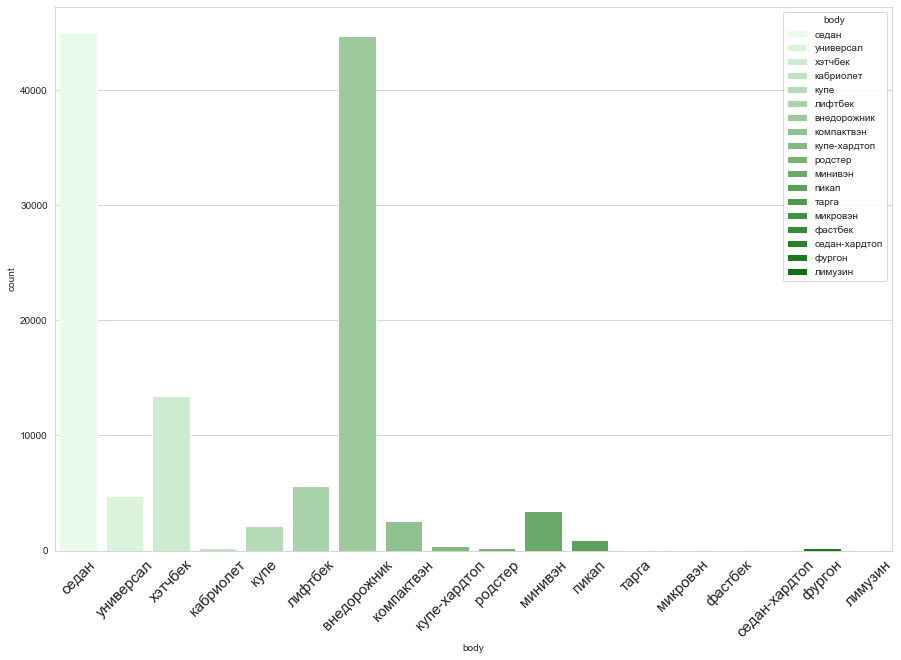

In [17]:
bar_count('body')

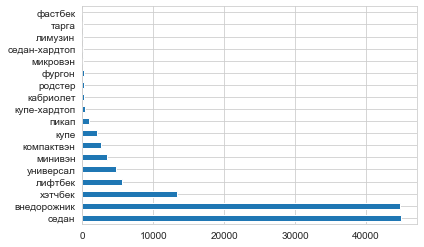

In [18]:
df.body.value_counts().plot.barh()

# Color

In [19]:
color_dict = {'CACECB': 'серебристый', 
              'FAFBFB':'белый', 
              'EE1D19':'красный', 
              '97948F':'серый',
              '660099':'пурпурный',
              '040001':'чёрный',
              '4A2197':'фиолетовый',
              '200204':'коричневый',
              '0000CC':'синий',
              '007F00':'зелёный',
              'C49648':'бежевый',
              '22A0F8':'голубой',
              'DEA522':'золотистый',
              'FFD600': 'жёлтый',
              'FF8649':'оранжевый',
              'FFC0CB':'розовый',
              'серебристый': 'серебристый', 
              'белый':'белый', 
              'красный':'красный', 
              'серый':'серый',
              'пурпурный':'пурпурный',
              'чёрный':'чёрный',
              'фиолетовый':'фиолетовый',
              'коричневый':'коричневый',
              'синий':'синий',
              'зелёный':'зелёный',
              'бежевый':'бежевый',
              'голубой':'голубой',
              'золотистый':'золотистый',
              'жёлтый': 'жёлтый',
              'оранжевый':'оранжевый',
              'розовый':'розовый'
             }
df.color = df.color.map(color_dict)

C:\Users\User\anaconda3\lib\site-packages\pandas\core\generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


No handles with labels found to put in legend.


чёрный : 29.2%
белый : 17.71%
серебристый : 12.45%
серый : 11.93%
синий : 9.8%
красный : 4.87%
коричневый : 4.09%
зелёный : 2.87%
бежевый : 2.01%
голубой : 1.5%
золотистый : 0.84%
пурпурный : 0.81%
жёлтый : 0.72%
фиолетовый : 0.66%
оранжевый : 0.52%
розовый : 0.03%


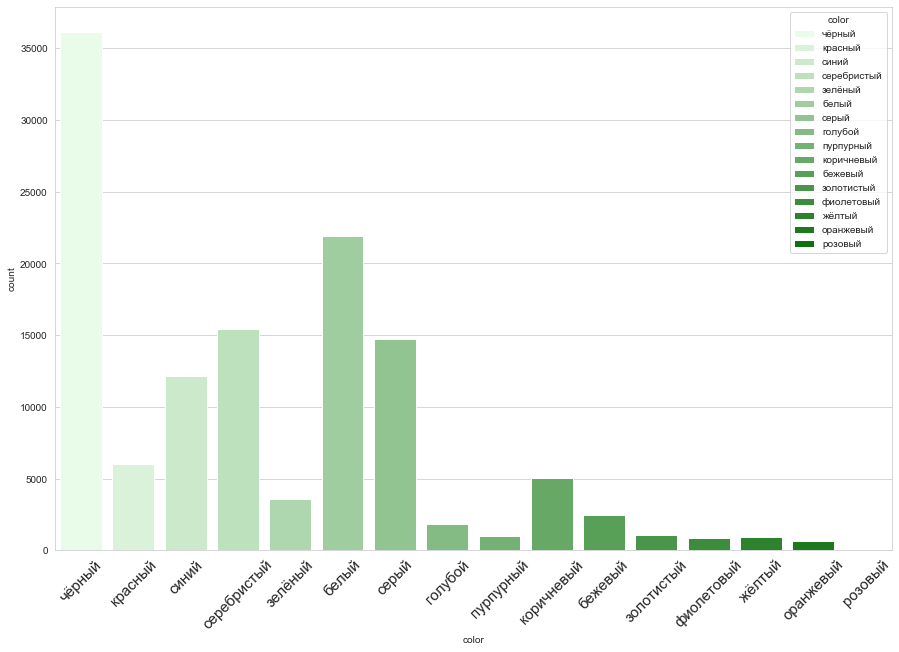

In [20]:
bar_count('color')

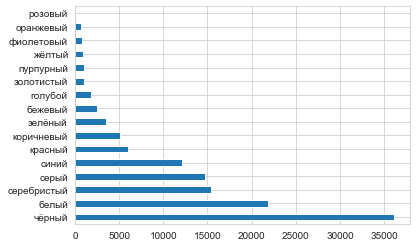

In [21]:
df.color.value_counts().plot.barh()

# Fuel

No handles with labels found to put in legend.


бензин : 83.55%
дизель : 15.88%
гибрид : 0.42%
электро : 0.13%
газ : 0.01%


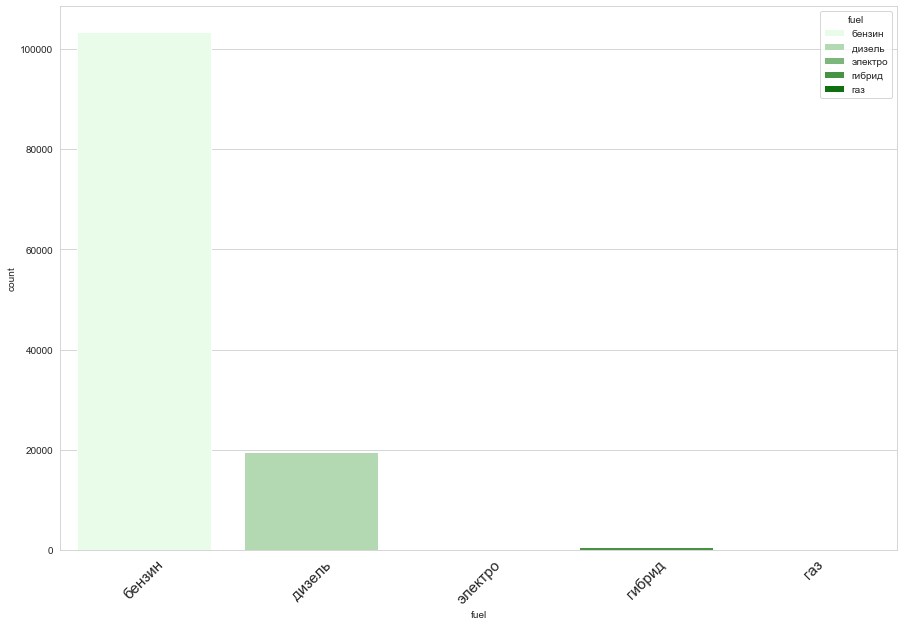

In [22]:
bar_count('fuel')

# model_date

No handles with labels found to put in legend.


3 : 45.59%
2 : 23.92%
4 : 14.21%
1 : 8.84%
0 : 7.45%


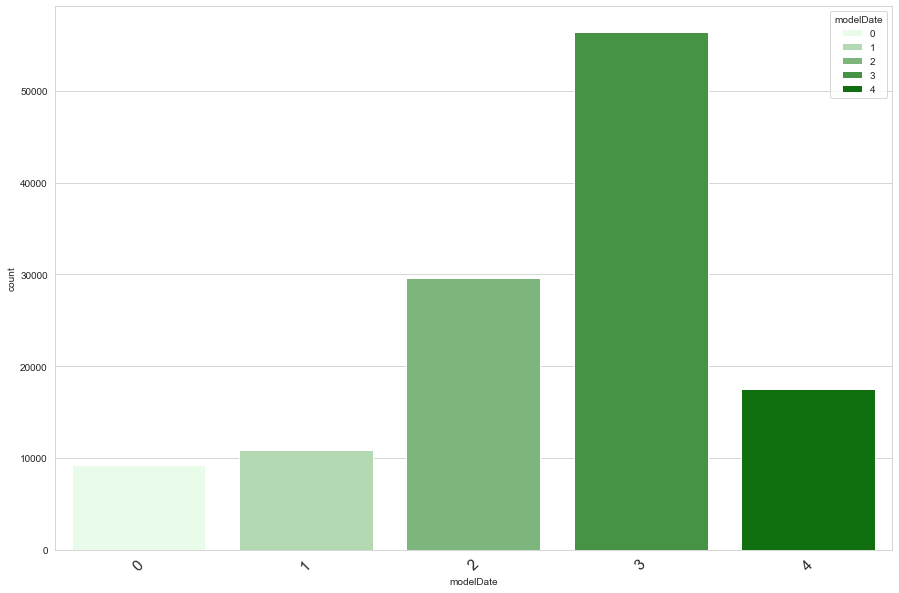

In [23]:
date = []
for i in df.modelDate:
    date.append(str(i).replace('.0',''))
    
df.modelDate = date
df.modelDate = pd.to_datetime(df.modelDate)

class_ = []
for i in df.modelDate:
    year = int(((datetime.today() - i).days)/365)
    if year <= 3:
        class_.append(0)
    elif year > 3 and year <= 5:
        class_.append(1)
    elif year > 5 and year <= 10:    
        class_.append(2)
    elif year > 10 and year <= 20:    
        class_.append(3)
    else:
        class_.append(4)
        
df.modelDate = class_   
bar_count('modelDate')

# Engine

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No handles with labels found to put in legend.


Малый : 51.73%
Средний : 40.96%
Большой : 4.36%
Особо малый : 1.76%
Высший : 1.19%


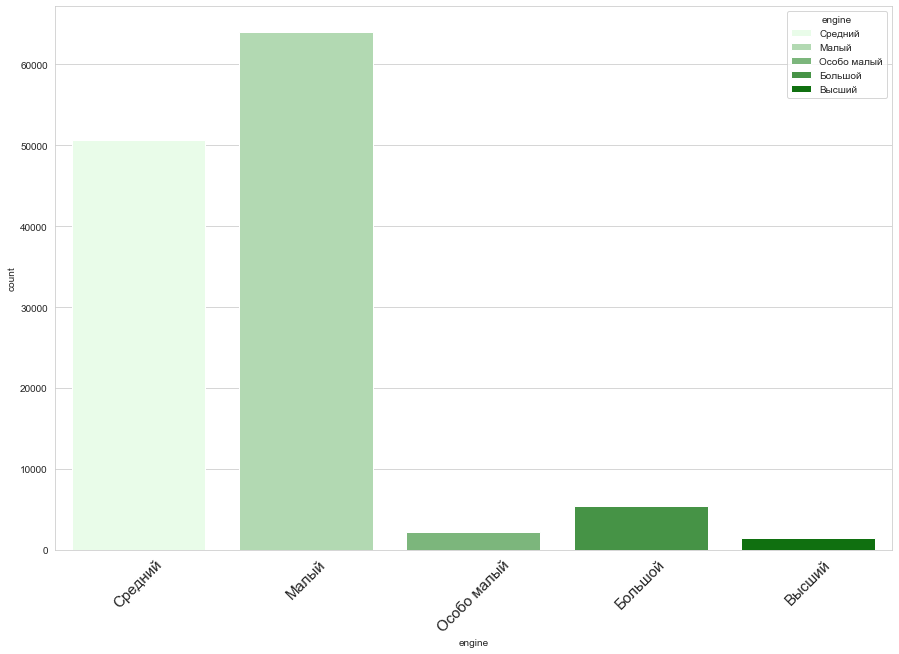

In [24]:
engine = []
for i in df['engine']:
    flag = str(i).find('.')
    if flag > 0:
        engine.append(i[flag-1:flag+2])
    else:
        engine.append(None)
        
df.engine = engine
# Заполним пропуски
df.engine = df.engine.fillna(1.6)
df["engine"] = df["engine"].astype(float)

# Заменим данные на категориальные
clas = []
for x in df["engine"]:
    if x <= 1.2: 
        clas.append('Особо малый')
    elif 1.3 <= x <= 1.8: 
        clas.append('Малый')
    elif 1.9 <= x <= 3.5: 
        clas.append('Средний')
    elif 3.6 <= x <= 5.0: 
        clas.append('Большой')
    elif x >= 5.1: 
        clas.append('Высший')
        
df["engine"] = clas
bar_count('engine')

# Power

In [25]:
df.power = [int(str(i).replace(' N12','').replace('.0','')) for i in df.power] 

In [26]:
def engine_power(x):
    if x < 100: x = 1
    elif 99 < x < 150: x = 2
    elif 149 < x < 200: x = 3
    elif 199 < x < 250: x = 4
    elif 249 < x < 300: x = 5
    elif 299 < x < 350: x = 6
    elif 349 < x < 400: x = 7
    elif 399 < x < 450: x = 8
    elif 449 < x < 500: x = 9
    elif 499 < x < 550: x = 10
    elif 549 < x < 600: x = 11
    elif 599 < x: x = 12
    return x  
df.power = df.power.map(engine_power)

No handles with labels found to put in legend.


2 : 35.6%
3 : 27.04%
4 : 14.49%
1 : 9.96%
5 : 4.39%
6 : 3.83%
7 : 1.76%
8 : 1.23%
11 : 0.56%
10 : 0.48%
9 : 0.46%
12 : 0.19%


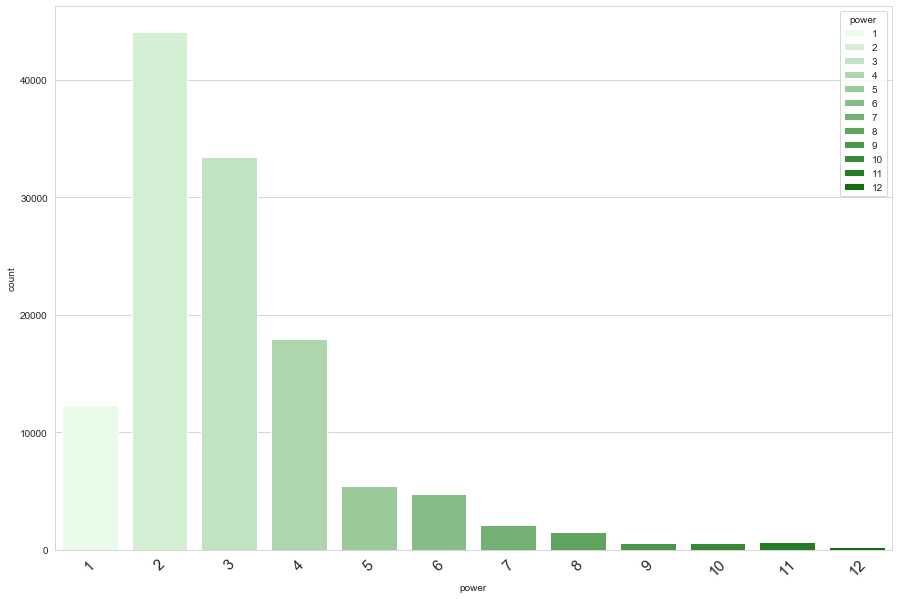

In [27]:
bar_count('power')

# mileage

No handles with labels found to put in legend.


2 : 35.6%
3 : 27.04%
4 : 14.49%
1 : 9.96%
5 : 4.39%
6 : 3.83%
7 : 1.76%
8 : 1.23%
11 : 0.56%
10 : 0.48%
9 : 0.46%
12 : 0.19%


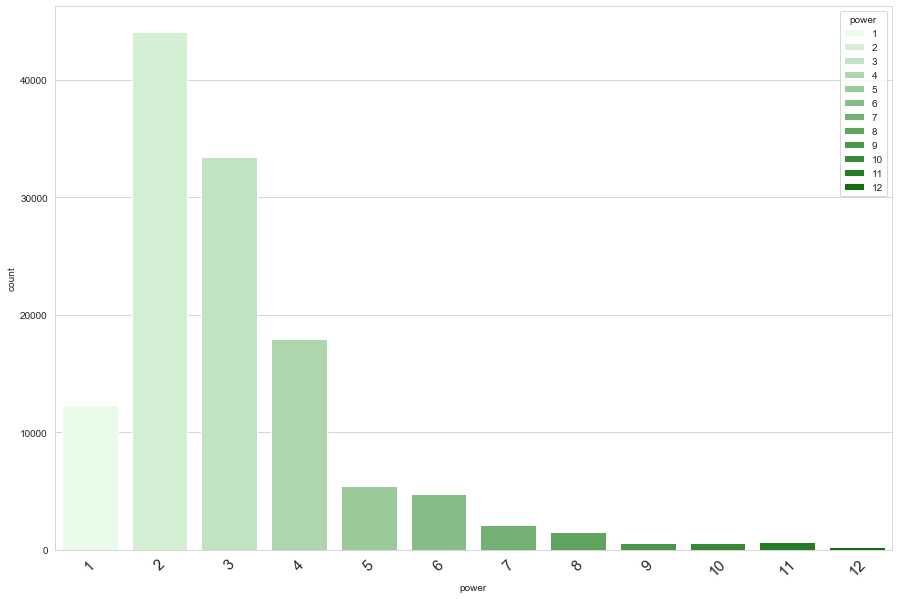

In [28]:
def mile_age(x):
    if x < 20000: x = 1
    elif 19999 < x < 40000: x = 2
    elif 39999 < x < 60000: x = 3
    elif 59999 < x < 80000: x = 4
    elif 79999 < x < 100000: x = 5
    elif 99999 < x < 200000: x = 6
    elif 199999 < x < 500000: x = 7
    elif 499999 < x: x = 8
    return x  
df.mileage = df.mileage.map(mile_age)
bar_count('power')

# Wheel

In [29]:
df.wheel.value_counts()

LEFT      87185
Левый     33287
RIGHT      1782
Правый     1399
Name: wheel, dtype: int64

No handles with labels found to put in legend.


LEFT : 97.43%
RIGHT : 2.57%


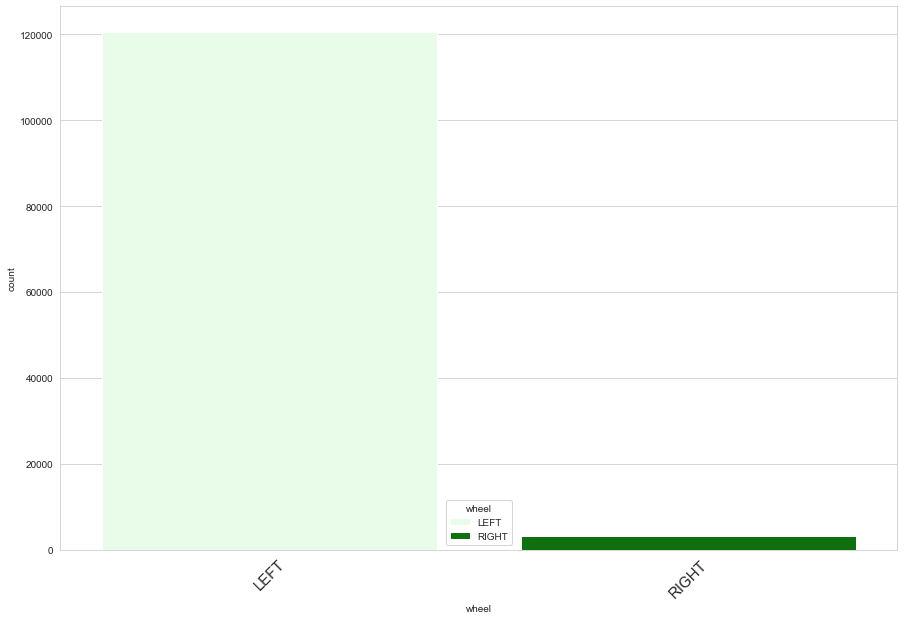

In [30]:
wheel = {'LEFT': 'LEFT', 
              'Левый':'LEFT', 
              'RIGHT':'RIGHT', 
              'Правый':'RIGHT',

             }
df.wheel = df.wheel.map(wheel)
df.wheel = df.wheel.fillna('LEFT')
bar_count('wheel')

# Tech_passport

In [31]:
df.tech_passport.value_counts()

ORIGINAL     78230
Оригинал     30098
DUPLICATE    10376
Дубликат      4587
Name: tech_passport, dtype: int64

In [32]:
pts = {'ORIGINAL': 'ORIGINAL', 
              'Оригинал':'ORIGINAL', 
              'DUPLICATE':'DUPLICATE', 
              'Дубликат':'DUPLICATE',

             }
df.tech_passport = df.tech_passport.map(pts)
df.tech_passport = df.tech_passport.fillna('ORIGINAL')

No handles with labels found to put in legend.


ORIGINAL : 87.9%
DUPLICATE : 12.1%


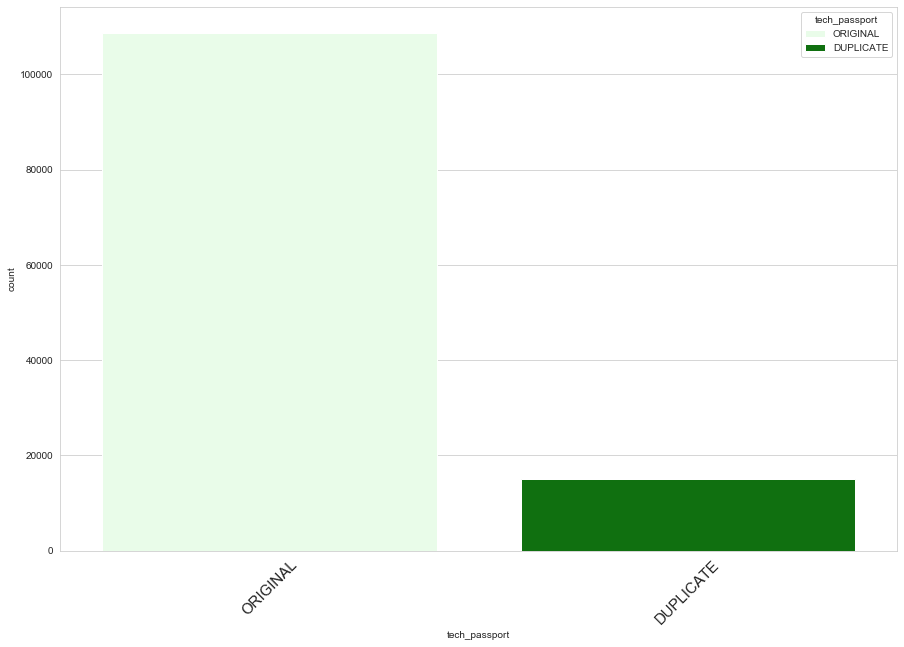

In [33]:
bar_count('tech_passport')

# Doors

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
No handles with labels found to put in legend.


5 : 56.67%
4 : 38.52%
2 : 2.5%
3 : 2.31%
0 : 0.0%


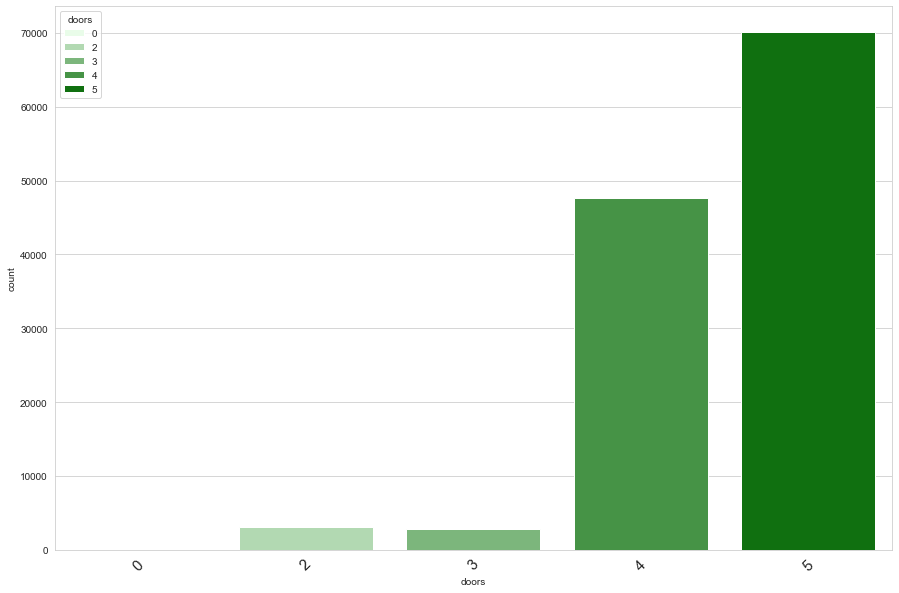

In [34]:
df['doors'] = df['doors'].astype(int)
bar_count('doors')

# Prod_date

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
No handles with labels found to put in legend.


average : 31.66%
young : 28.54%
old : 23.25%
retro : 16.55%


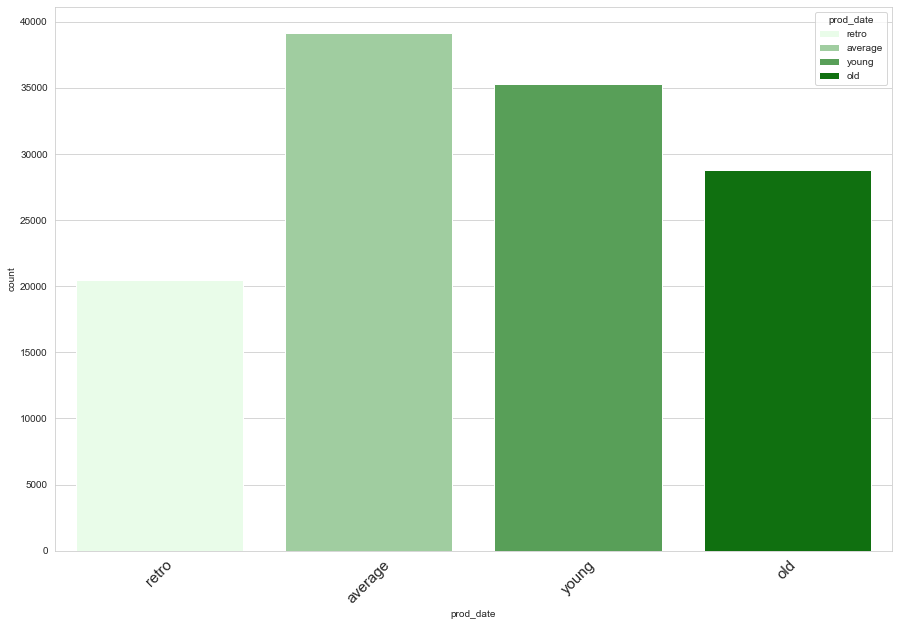

In [35]:
start = 2020

clas = []
for i in df['prod_date']:
    age = start - i
    if age <= 5:
        clas.append('young')
    elif 6 <= age <= 10:
        clas.append('average')
    elif 11 <= age <= 15:
        clas.append('old')
    else:
        clas.append('retro')
        
df['prod_date'] = clas
bar_count('prod_date')

# Config

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
No handles with labels found to put in legend.


AUTOMATIC : 55.44%
MECHANICAL : 26.18%
ROBOT : 9.48%
VARIATOR : 8.9%


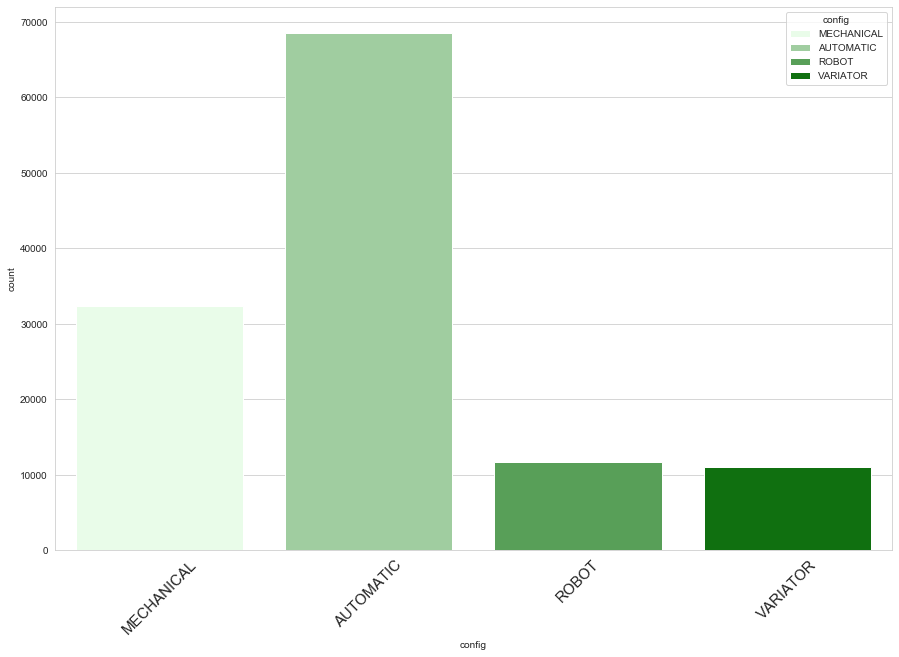

In [36]:
config = []
for i in df['config']:
    if i.find('MECHANICAL') > 0:
        config.append('MECHANICAL')
    elif i.find('AUTOMATIC') > 0:
        config.append('AUTOMATIC')
    elif i.find('VARIATOR') > 0:
        config.append('VARIATOR')
    elif i.find('ROBOT') > 0:
        config.append('ROBOT')
    else:
        print('undetify_type')
        
df['config'] = config
bar_count('config')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123653 entries, 0 to 123653
Data columns (total 17 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   brand          123653 non-null  object 
 1   body           123653 non-null  object 
 2   color          123653 non-null  object 
 3   fuel           123653 non-null  object 
 4   modelDate      123653 non-null  int64  
 5   doors          123653 non-null  int32  
 6   prod_date      123653 non-null  object 
 7   config         123653 non-null  object 
 8   engine         123653 non-null  object 
 9   power          123653 non-null  int64  
 10  mileage        123653 non-null  int64  
 11  drive          123653 non-null  object 
 12  wheel          123653 non-null  object 
 13  owner          123653 non-null  int32  
 14  tech_passport  123653 non-null  object 
 15  price          88967 non-null   float64
 16  train          123653 non-null  int64  
dtypes: float64(1), int32(2), int6

# Оценка корреляций

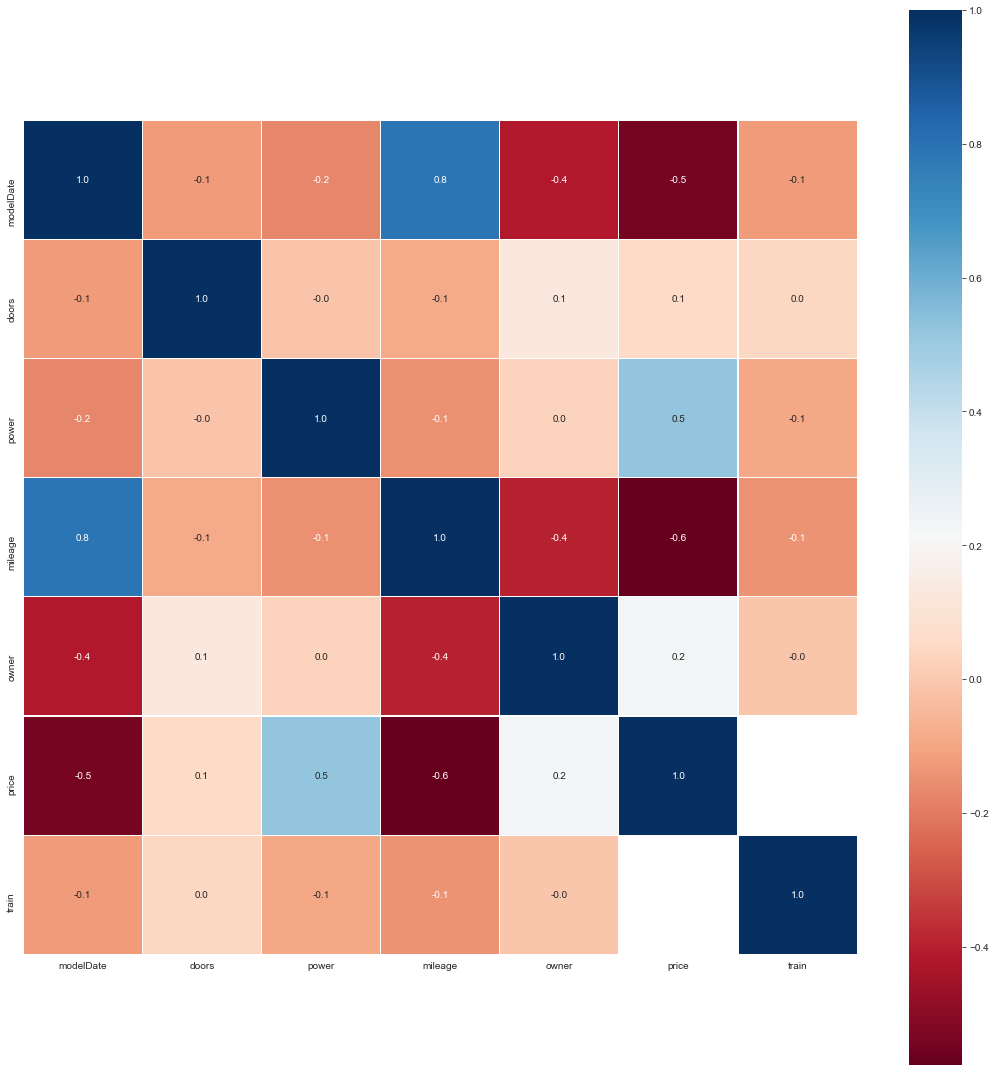

In [38]:
plt.rcParams['figure.figsize'] = (15,15)
sns.heatmap(df.corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu");
plt.tight_layout()

In [39]:
# Удалим колонку mileage, т.к сильно коррелирует с modelDate
df.drop('mileage', axis=1, inplace=True)
df

C:\Users\User\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,brand,body,color,fuel,modelDate,doors,prod_date,config,engine,power,drive,wheel,owner,tech_passport,price,train
0,AUDI,седан,чёрный,бензин,4,4,retro,MECHANICAL,Средний,3,полный,LEFT,0,ORIGINAL,200000.0,1
1,AUDI,седан,красный,бензин,4,4,retro,MECHANICAL,Малый,1,передний,LEFT,0,ORIGINAL,60000.0,1
2,AUDI,универсал,синий,бензин,4,5,retro,MECHANICAL,Средний,2,полный,LEFT,0,ORIGINAL,99000.0,1
3,AUDI,седан,серебристый,бензин,4,4,retro,MECHANICAL,Малый,1,передний,LEFT,0,ORIGINAL,65000.0,1
4,AUDI,седан,чёрный,бензин,4,4,retro,MECHANICAL,Средний,2,передний,LEFT,0,DUPLICATE,100000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123649,BMW,седан,коричневый,бензин,2,4,average,AUTOMATIC,Малый,2,задний,LEFT,0,ORIGINAL,NaN,0
123650,BMW,седан,чёрный,дизель,1,4,young,AUTOMATIC,Средний,3,полный,LEFT,2,ORIGINAL,NaN,0
123651,BMW,седан,серый,бензин,4,4,retro,AUTOMATIC,Средний,3,задний,LEFT,0,DUPLICATE,NaN,0
123652,BMW,внедорожник,коричневый,дизель,2,5,average,AUTOMATIC,Средний,3,полный,LEFT,1,ORIGINAL,NaN,0


# Сгруппируем признаки по типу

In [40]:
def data_category(df):   
        
    c_col = [col for col in df.columns if df[col].dtype.name == 'object' and df[col].nunique() > 2]
    n_col = [col for col in df.columns if df[col].dtype.name != 'object' and df[col].nunique() > 2]
    b_col = [col for col in df.columns if df[col].nunique() == 2]

    print(f'Количество категориальных признаков: {len(c_col)}')
    print(c_col)
    print(90*'=')
    print(f'Количество числовых признаков: {len(n_col)}')
    print(n_col)
    print(90*'=')
    print(f'Количество бинарных признаков: {len(b_col)}')
    print(b_col)
    return c_col, n_col, b_col

cat_cols, num_cols, bin_cols = data_category(df)

Количество категориальных признаков: 8
['brand', 'body', 'color', 'fuel', 'prod_date', 'config', 'engine', 'drive']
Количество числовых признаков: 5
['modelDate', 'doors', 'power', 'owner', 'price']
Количество бинарных признаков: 3
['wheel', 'tech_passport', 'train']


# Определим значимость  по ANOVA F test

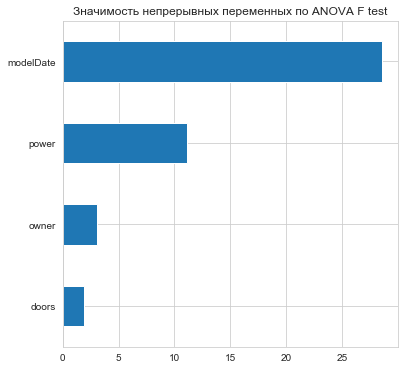

In [41]:
df_tr = df[df.train==1]
num_cols = num_cols[:-1]
imp_num = Series(f_classif(df_tr[num_cols], df_tr['price'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
fig = plt.figure(figsize=(6,6))
imp_num.plot(kind = 'barh', title='Значимость непрерывных переменных по ANOVA F test')

# Значимость категориальных и бинарных переменных

Для оценки значимости категориальных и бинарных переменных будем использовать функцию mutual_info_classif из библиотеки sklearn. Данная функция опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.

In [42]:
# Для бинарных признаков мы будем использовать LabelEncoder
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    
for column in cat_cols:
    df[column] = label_encoder.fit_transform(df[column])

df

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,brand,body,color,fuel,modelDate,doors,prod_date,config,engine,power,drive,wheel,owner,tech_passport,price,train
0,0,11,15,0,4,4,2,1,4,3,2,0,0,1,200000.0,1
1,0,11,7,0,4,4,2,1,2,1,1,0,0,1,60000.0,1
2,0,14,13,0,4,5,2,1,4,2,2,0,0,1,99000.0,1
3,0,11,11,0,4,4,2,1,2,1,1,0,0,1,65000.0,1
4,0,11,15,0,4,4,2,1,4,2,1,0,0,0,100000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123649,1,11,6,0,2,4,0,0,2,2,0,0,0,1,NaN,0
123650,1,11,15,3,1,4,3,0,4,3,2,0,2,1,NaN,0
123651,1,11,12,0,4,4,2,0,4,3,0,0,0,0,NaN,0
123652,1,0,6,3,2,5,0,0,4,3,2,0,1,1,NaN,0


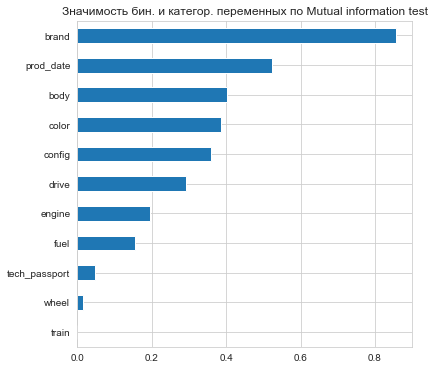

In [43]:
df_tr = df[df.train==1]
imp_cat = Series(mutual_info_classif(df_tr[bin_cols + cat_cols], df_tr['price'],
                                     discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
fig = plt.figure(figsize=(6,6))
imp_cat.plot(kind = 'barh', title = 'Значимость бин. и категор. переменных по Mutual information test');

In [44]:
df.columns

Index(['brand', 'body', 'color', 'fuel', 'modelDate', 'doors', 'prod_date',
       'config', 'engine', 'power', 'drive', 'wheel', 'owner', 'tech_passport',
       'price', 'train'],
      dtype='object')

In [45]:
for colum in ['brand', 'body', 'color', 'fuel', 'modelDate', 'doors', 'prod_date',
       'config', 'engine', 'power', 'drive', 'wheel', 'owner', 'tech_passport']:
    df[colum] = df[colum].astype('category').cat.codes

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 123653 entries, 0 to 123653
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   brand          123653 non-null  int8   
 1   body           123653 non-null  int8   
 2   color          123653 non-null  int8   
 3   fuel           123653 non-null  int8   
 4   modelDate      123653 non-null  int8   
 5   doors          123653 non-null  int8   
 6   prod_date      123653 non-null  int8   
 7   config         123653 non-null  int8   
 8   engine         123653 non-null  int8   
 9   power          123653 non-null  int8   
 10  drive          123653 non-null  int8   
 11  wheel          123653 non-null  int8   
 12  owner          123653 non-null  int8   
 13  tech_passport  123653 non-null  int8   
 14  price          88967 non-null   float64
 15  train          123653 non-null  int64  
dtypes: float64(1), int64(1), int8(14)
memory usage: 9.5 MB


In [47]:
temp_df = df[df['train']==1]
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88967 entries, 0 to 88967
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   brand          88967 non-null  int8   
 1   body           88967 non-null  int8   
 2   color          88967 non-null  int8   
 3   fuel           88967 non-null  int8   
 4   modelDate      88967 non-null  int8   
 5   doors          88967 non-null  int8   
 6   prod_date      88967 non-null  int8   
 7   config         88967 non-null  int8   
 8   engine         88967 non-null  int8   
 9   power          88967 non-null  int8   
 10  drive          88967 non-null  int8   
 11  wheel          88967 non-null  int8   
 12  owner          88967 non-null  int8   
 13  tech_passport  88967 non-null  int8   
 14  price          88967 non-null  float64
 15  train          88967 non-null  int64  
dtypes: float64(1), int64(1), int8(14)
memory usage: 3.2 MB


In [48]:
X = df.query('train == 1').drop(['train','price'], axis=1)
X_sub = df.query('train == 0').drop(['train','price'], axis=1)
y = temp_df['price']

# Train Split

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, 
                                                    random_state=RANDOM_SEED)

#  GradientBoostingRegressor

Эта модель будет предсказывать среднюю цену по модели двигателя (brand). C ней будем сравнивать другие модели.

In [50]:
def gb_model (y,x):
    gb = GradientBoostingRegressor(min_samples_split=2, learning_rate=0.03, max_depth=10, n_estimators=1000)
    gb.fit(x,y)
    return gb

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [51]:
gb_model = gb_model(y_train,X_train)

In [52]:
test_predict = gb_model.predict(X_test)
test_score = mape(y_test, test_predict)
print(f"Точность модели по метрике MAPE: {mape(y_test, test_predict):0.3f}")

Точность модели по метрике MAPE: 0.185


# ExtraTreesRegressor

In [53]:
def et_model (y,x):
    et = ExtraTreesRegressor(max_depth=15,max_features = 'sqrt',
                             n_estimators = 1000, random_state = 42, n_jobs = -1)
    et.fit(x,y)
    return et

In [54]:
et_model = et_model(y_train,X_train)

In [55]:
test_predict = et_model.predict(X_test)
test_score = mape(y_test, test_predict)
print(f"Точность модели по метрике MAPE: {mape(y_test, test_predict):0.3f}")

Точность модели по метрике MAPE: 0.251


# RandomForestRegressor

In [56]:
def reg_model(y, x):
    reg = RandomForestRegressor(n_estimators=1000, n_jobs = -1, max_depth = 15, max_features = 'log2', random_state = 42, oob_score=True,) 
    reg.fit(x,y) 
    return reg

In [57]:
reg_model = reg_model(y_train,X_train)

In [58]:
test_predict = reg_model.predict(X_test)
test_score = mape(y_test, test_predict)
print(f"Точность модели по метрике MAPE: {mape(y_test, test_predict):0.3f}")

Точность модели по метрике MAPE: 0.216


# Fit

In [59]:
cv = KFold(n_splits=10, shuffle=True, random_state=42)
#cv = KFold(n_splits=N_FOLDS, shuffle=True)

In [60]:
X_train = np.where(np.isnan(X_train), 0, X_train)
X_test = np.where(np.isnan(X_test), 0, X_test)
y_train = np.where(np.isnan(y_train), 0, y_train)

In [61]:
from sklearn.base import clone
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

In [62]:
def compute_meta_feature(clf, X_train, X_test, y_train, cv):
    
    #n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros(len(y_train), dtype=np.float32)

    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
        X_fold_train, X_fold_predict = X_train[train_fold_index], X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_clf = clone(clf)
        folded_clf.fit(X_fold_train, y_fold_train)
        
        X_meta_train[predict_fold_index] = folded_clf.predict(X_fold_predict)
    
    meta_clf = clone(clf)
    meta_clf.fit(X_train, y_train)
    
    X_meta_test = meta_clf.predict(X_test)
    
    n = cv.n_splits
    X_meta_test = X_meta_test / n

    
    return X_meta_train, X_meta_test

In [63]:
def generate_meta_features(classifiers, X_train, X_test, y_train, cv):
    features = [compute_meta_feature(clf, X_train, X_test, y_train, cv) for clf in tqdm(classifiers)]
    stacked_features_train = np.hstack([features_train for features_train, features_test in features])
    stacked_features_test = np.hstack([features_test for features_train, features_test in features])
    return stacked_features_train, stacked_features_test

In [64]:
clf = KNeighborsRegressor()
KNeighborsClassifier()

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [65]:
clf = KNeighborsRegressor()
n_classes = len(np.unique(y_train))
X_meta_train = np.zeros((len(y_train), n_classes), dtype=np.float32)
X_meta_train = np.zeros(len(y_train), dtype = np.float32)
splits = cv.split(X_train)

for train_fold_index, predict_fold_index in splits:
    folded_clf = clone(clf)
    folded_clf.fit(X_train[train_fold_index], y_train[train_fold_index])
    X_meta_train[predict_fold_index] = folded_clf.predict(X_train[predict_fold_index])

meta_clf = clone(clf)
meta_clf.fit(X_train, y_train)
X_meta_test = meta_clf.predict(X_test)

In [66]:
stacked_features_train, stacked_features_test = generate_meta_features([
    #RandomForestRegressor(n_estimators=100),
    #GradientBoostingClassifier
    #GradientBoostingRegressor(n_estimators=100),
    #KNeighborsRegressor()
    KNeighborsClassifier()
    #ExtraTreesClassifier(n_estimators=100)
], X_train, X_test, y_train, cv)

In [67]:
stacked_features_train.shape

(71173,)

In [68]:
y_train.shape

(71173,)

In [69]:
stacked_features_train = stacked_features_train.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)

In [70]:
stacked_features_train.shape

(71173, 1)

In [71]:
test_predict = meta_clf.predict(X_test)
test_score = mape(y_test, test_predict)
print(f"Точность модели по метрике MAPE: {mape(y_test, test_predict):0.3f}")

Точность модели по метрике MAPE: 0.228


# Submission

In [73]:
predict_submission = gb_model.predict(X_sub)

sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission_v{VERSION}.csv', index=False)
sample_submission.head(10)